Topgivity Dataset: 135 False Positives Predictions in common

Complete Dataset: 148 False Positives Predictions in common

Space Datasets: Total 267 predictions in both training & discovery spaces

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [24]:
def run_ml_algo(file):
    df = pd.read_csv(file)

    df.columns = [['space_group','compound','f1','f2','f3','f4','category']]
    x = df.iloc[:, 2:6]
    y = df.iloc[:,6]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=45, stratify = y)
    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', x_test.shape)
    print()

    models = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
    ac_s = []
    pc_s = []
    rc_s = []
    f1_s = []
    cm = [] # For Confusion Matrices
    lr_param = []   # Logistic Regression Parameters
    pred_mat = []   # Predictin Dataframe

    for i in range(len(models)):
        model = models[i]
        classifier = model.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

        if i == 0:  # For getting Logistic Regression Parameters
            for _ in np.ndenumerate(classifier.coef_):
                lr_param.append(_[1])
            lr_param.append(classifier.intercept_[0])

            # Checking Logistic Regression threshold
            probs_y = classifier.predict_proba(x_test)
            check = np.zeros(y_pred.shape)
            thresh = 0.5
            for i in range(len(probs_y)):
                if probs_y[i][0] < 0.5:
                    check [i] = 1
                else:
                    check[i] = 0
            if np.array_equal(y_pred, check): print('Logistic Regression Threshold =', thresh)
            else:
                print('Threshold', thresh, 'not appropriate!')
        
        # Confusion Matrix
        cm.append(confusion_matrix(y_test, y_pred))
    
        # Predicting
        false_pos = np.logical_and(y_test != y_pred, y_pred == 1)
        false_mat = x_test[false_pos].index
        pred = pd.DataFrame(columns=('Space_Group', 'Compound', 'Category'))
        for i in range(len(false_mat)):
            j = df.loc[[df.index[false_mat[i]]]]
            pred.loc[len(pred)] = [str(j.space_group).split()[2], str(j.compound).split()[2], str(j.category).split()[2]]
        train_pred = classifier.predict(x_train)
        false_pos = np.logical_and(y_train != train_pred, train_pred == 1)
        false_mat = x_train[false_pos].index
        for i in range(len(false_mat)):
            j = df.loc[[df.index[false_mat[i]]]]
            pred.loc[len(pred)] = [str(j.space_group).split()[2], str(j.compound).split()[2], str(j.category).split()[2]]
        pred_mat.append(pred)
    
        ac_s.append(accuracy_score(y_test, y_pred))
        pc_s.append(precision_score(y_test, y_pred))
        rc_s.append(recall_score(y_test, y_pred))
        f1_s.append(f1_score(y_test, y_pred))
    
    print()
    print('Logistic Regression Parameters (w1, w2, w3, w4, b) for', file + ':\n', lr_param)
    print()
    
    print()
    print('For', file + ':')
    classification_metrics_df = pd.DataFrame({
        "Model": ["Logistic Regression", "SVM", "Decision Tree", "Random Forest"],
        "Accuracy": ac_s,
        "Precision": pc_s,
        "Recall": rc_s,
        "F1 Score": f1_s
    })
    classification_metrics_df.set_index('Model', inplace=True)
    display(classification_metrics_df)
    print()
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    l = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest']
    _ = 0
    for i in range(len(cm)):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
        if i > 1:
            _ = 1
            disp.plot(cmap='Blues', ax=axes[_, i-2])
        else:
            disp.plot(cmap='Blues', ax=axes[_, i])
        disp.ax_.set_title(l[i])
    
    plt.show()
    
    print()
    # False Positives, Potential Topological Materials
    pd.set_option('display.max_rows', None)
    for i in range(len(pred_mat)):
        print('Number of False Positives of', l[i] + ':', pred_mat[i].shape[0])
        print()
    
    potential_topological = []
    lr_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[0].itertuples()]
    svm_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[1].itertuples()]
    dt_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[2].itertuples()]
    rf_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[3].itertuples()]
    for i in rf_false_positives:
        if i in lr_false_positives and i in svm_false_positives and i in dt_false_positives: potential_topological.append(i)
    
    print('Total predictions =', len(potential_topological))
    
    
    with open('results\\'+file.split('_')[0]+'_known_predictions.csv', 'w', newline='') as f1:
        w1 = csv.writer(f1)
        with open('results\\'+file.split('_')[0]+'_unknown_predictions.csv', 'w', newline='') as f2:
            w2 = csv.writer(f2)
            for i in potential_topological:
                if i[0] == 'Unknown': w2.writerow(i)
                else: w1.writerow(i)
    print('Results written to file!')
    
    return potential_topological

SPACED DATASET ML ALGORITHM

x_train shape: (7652, 4)
x_test shape: (1913, 4)
y_train shape: (7652,)
y_test shape: (1913, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9565 entries, 0 to 9564
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (space_group,)  9565 non-null   object 
 1   (compound,)     9565 non-null   object 
 2   (f1,)           9565 non-null   float64
 3   (f2,)           9565 non-null   float64
 4   (f3,)           9565 non-null   float64
 5   (f4,)           9565 non-null   float64
 6   (category,)     9565 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 523.2+ KB
None

Logistic Regression Threshold = 0.5
Logistic Regression Parameters (w1, w2, w3, w4, b) for Space Datasets:
 [-0.008501526488163857, 0.37181752933107004, -0.22955395405246665, -0.2610647341151176, 0.961304066075661]


For Space Datasets:


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.841610,0.818763,0.852386,0.835237
SVM,0.846837,0.835541,0.840178,0.837853
Decision Tree,0.811291,0.800000,0.799112,0.799556
Random Forest,0.851542,0.841639,0.843507,0.842572


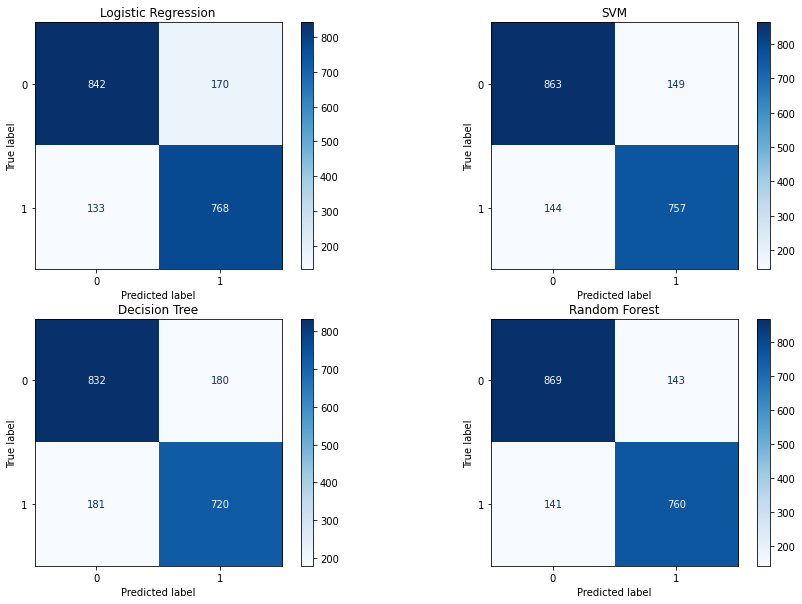

Number of False Positives of Logistic Regression: 1053

Number of False Positives of SVM: 935

Number of False Positives of Decision Tree: 506

Number of False Positives of Random Forest: 442


Total predictions = 267

Results Written to file!


In [5]:
df = pd.read_csv('space_datasets\\training_space_ml_dataset.csv')

df.columns = [['space_group','compound','f1','f2','f3','f4','category']]
x = df.iloc[:, 2:6]
y = df.iloc[:,6]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=45, stratify = y)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', x_test.shape)
print()
print(df.info())
print()

# Discovery Space dataframe
discovery_df = pd.read_csv('space_datasets\\discovery_space_prediction_dataset.csv')
discovery_df.columns = [['space_group','compound','f1','f2','f3','f4','category']]
discovery_x = discovery_df.iloc[:, 2:6]
discovery_y = discovery_df.iloc[:,6]

models = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
ac_s = []
pc_s = []
rc_s = []
f1_s = []
cm = [] # For Confusion Matrices
lr_param = []   # Logistic Regression Parameters
pred_mat = []   # Predictin Dataframe

for i in range(len(models)):
    model = models[i]
    classifier = model.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)

    if i == 0:  # For getting Logistic Regression Parameters
        for _ in np.ndenumerate(classifier.coef_):
            lr_param.append(_[1])
        lr_param.append(classifier.intercept_[0])

        # Checking Logistic Regression threshold
        probs_y = classifier.predict_proba(x_test)
        check = np.zeros(y_pred.shape)
        thresh = 0.5
        for i in range(len(probs_y)):
            if probs_y[i][0] < 0.5:
                check [i] = 1
            else:
                check[i] = 0
        if np.array_equal(y_pred, check): print('Logistic Regression Threshold =', thresh)
        else:
            print('Threshold', thresh, 'not appropriate!')
    
    # Confusion Matrix
    cm.append(confusion_matrix(y_test, y_pred))

    # Predicting
    false_pos = np.logical_and(y_test != y_pred, y_pred == 1)
    false_mat = x_test[false_pos].index
    pred = pd.DataFrame(columns=('Space_Group', 'Compound', 'Category'))
    for i in range(len(false_mat)):
        j = df.loc[[df.index[false_mat[i]]]]
        pred.loc[len(pred)] = [str(j.space_group).split()[2], str(j.compound).split()[2], str(j.category).split()[2]]
    train_pred = classifier.predict(x_train)
    false_pos = np.logical_and(y_train != train_pred, train_pred == 1)
    false_mat = x_train[false_pos].index
    for i in range(len(false_mat)):
        j = df.loc[[df.index[false_mat[i]]]]
        pred.loc[len(pred)] = [str(j.space_group).split()[2], str(j.compound).split()[2], str(j.category).split()[2]]

    # Predicting Discovery Space Materials
    discovery_pred = classifier.predict(discovery_x)
    false_pos = np.logical_and(discovery_pred != discovery_y, discovery_pred == 1)
    false_mat = discovery_x[false_pos].index
    for i in range(len(false_mat)):
        j = discovery_df.loc[[discovery_df.index[false_mat[i]]]]
        pred.loc[len(pred)] = [str(j.space_group).split()[2], str(j.compound).split()[2], str(j.category).split()[2]]

    pred_mat.append(pred)

    ac_s.append(accuracy_score(y_test, y_pred))
    pc_s.append(precision_score(y_test, y_pred))
    rc_s.append(recall_score(y_test, y_pred))
    f1_s.append(f1_score(y_test, y_pred))

print('Logistic Regression Parameters (w1, w2, w3, w4, b) for Space Datasets:\n', lr_param)
print()

print()
print('For Space Datasets:')
classification_metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Decision Tree", "Random Forest"],
    "Accuracy": ac_s,
    "Precision": pc_s,
    "Recall": rc_s,
    "F1 Score": f1_s
})
classification_metrics_df.set_index('Model', inplace=True)
display(classification_metrics_df)
print()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
l = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest']
_ = 0
for i in range(len(cm)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    if i > 1:
        _ = 1
        disp.plot(cmap='Blues', ax=axes[_, i-2])
    else:
        disp.plot(cmap='Blues', ax=axes[_, i])
    disp.ax_.set_title(l[i])

plt.show()

# False Positives, Potential Topological Materials
pd.set_option('display.max_rows', None)
for i in range(len(pred_mat)):
    print('Number of False Positives of', l[i] + ':', pred_mat[i].shape[0])
    print()

space_potential_topological = []
lr_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[0].itertuples()]
svm_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[1].itertuples()]
dt_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[2].itertuples()]
rf_false_positives = [(i.Space_Group, i.Compound) for i in pred_mat[3].itertuples()]
for i in rf_false_positives:
    if i in lr_false_positives and i in svm_false_positives and i in dt_false_positives: space_potential_topological.append(i)

print()
print('Total predictions =', len(space_potential_topological))
print()

with open('results\\space_known_predictions.csv', 'w', newline='') as f1:
    w1 = csv.writer(f1)
    with open('results\\space_unknown_predictions.csv', 'w', newline='') as f2:
        w2 = csv.writer(f2)
        for i in space_potential_topological:
            if i[0] == 'Unknown': w2.writerow(i)
            else: w1.writerow(i)

print('Results Written to file!')

TOPOGIVITY DATASET ML ALGORITHM

x_train shape: (8648, 4)
x_test shape: (2163, 4)
y_train shape: (8648,)
y_test shape: (2163, 4)

Logistic Regression Threshold = 0.5

Logistic Regression Parameters (w1, w2, w3, w4, b) for topogivity_ml_dataset.csv:
 [0.2998671702359927, 0.3874831423024836, -0.004045356068017156, -0.22211083649695987, 0.26331366792500627]


For topogivity_ml_dataset.csv:


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.840962,0.816262,0.819724,0.817989
SVM,0.840499,0.822198,0.809120,0.815607
Decision Tree,0.802589,0.783516,0.756098,0.769563
Random Forest,0.853444,0.842451,0.816543,0.829295


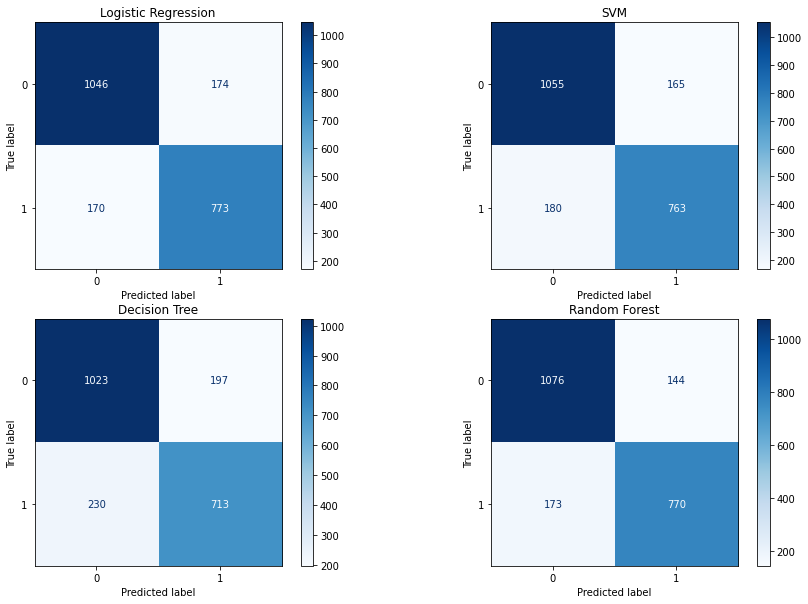


Number of False Positives of Logistic Regression: 904

Number of False Positives of SVM: 875

Number of False Positives of Decision Tree: 251

Number of False Positives of Random Forest: 254

Total predictions = 135
Results written to file!


In [21]:
topogivity_potential_topological = run_ml_algo('topogivity_ml_dataset.csv')

COMPLETE DATASET ML ALGORITHM

x_train shape: (9044, 4)
x_test shape: (2261, 4)
y_train shape: (9044,)
y_test shape: (2261, 4)

Logistic Regression Threshold = 0.5

Logistic Regression Parameters (w1, w2, w3, w4, b) for complete_ml_dataset.csv:
 [0.12133313540018882, 0.3858048138441524, -0.16080227595062357, -0.19655472032183122, 0.6071894444682711]


For complete_ml_dataset.csv:


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.849182,0.825447,0.817708,0.821559
SVM,0.853605,0.836364,0.814583,0.825330
Decision Tree,0.796992,0.766206,0.751042,0.758548
Random Forest,0.838567,0.816826,0.798958,0.807794


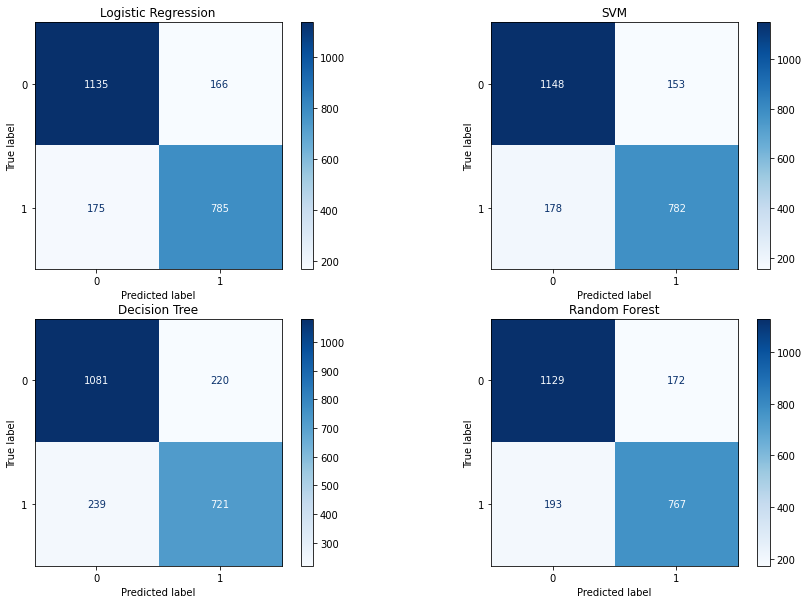


Number of False Positives of Logistic Regression: 877

Number of False Positives of SVM: 806

Number of False Positives of Decision Tree: 285

Number of False Positives of Random Forest: 313

Total predictions = 148
Results written to file!


In [25]:
complete_potential_topological = run_ml_algo('complete_ml_dataset.csv')

In [26]:
common_predictions_all_datasets = []

for i in complete_potential_topological:    # This gives predictions only from topogivity dataset that are common to all
    if i in space_potential_topological and i in topogivity_potential_topological: common_predictions_all_datasets.append(i)

common_predictions_all_datasets = sorted(common_predictions_all_datasets, key=lambda x: x[1])   # Sorting Alphabetically for easier checking

count_unknown_in_common = 0
count_known_in_common = 0

with open('results\\high_confidence_known_predictions.csv', 'w', newline='') as f1:
    w1 = csv.writer(f1)
    for i in common_predictions_all_datasets:
        if i[0] == 'Unknown': count_unknown_in_common += 1
        else:
            w1.writerow(i)
            count_known_in_common += 1

print('Total High Confidence Predictions with Unknown space groups =', count_unknown_in_common)
print('Total High Confidence Predictions with Known space groups =', count_known_in_common)

Total High Confidence Predictions with Unknown space groups = 0
Total High Confidence Predictions with Known space groups = 39


In [27]:
common_predictions_except_topogivity = []
for i in complete_potential_topological:
    if i in space_potential_topological: common_predictions_except_topogivity.append(i)

common_predictions_except_topogivity = sorted(common_predictions_except_topogivity, key=lambda x: x[1])   # Sorting Alphabetically for easier checking

count_unknown_in_common = 0
count_known_in_common = 0
count_not_in_common_dataset = 0

with open('results\\high_confidence_known_except_topogivity_predictions.csv', 'w', newline='') as f1:
    w1 = csv.writer(f1)
    for i in common_predictions_except_topogivity:
        if i[0] == 'Unknown': count_unknown_in_common += 1
        else: count_known_in_common += 1
        if i not in common_predictions_all_datasets:
            w1.writerow(i)
            count_not_in_common_dataset += 1

print('Total High Confidence Predictions with Unknown space groups =', count_unknown_in_common)
print('Total High Confidence Predictions with Known space groups =', count_known_in_common)
print('Total High Confidence Predictions not in common predictions of all datasets =', count_not_in_common_dataset)

Total High Confidence Predictions with Unknown space groups = 1
Total High Confidence Predictions with Known space groups = 77
Total High Confidence Predictions not in common predictions of all datasets = 39


In [31]:
# High Confidence Predictions except Topogivity with Unknown space groups
complete_unknown_predictions = []
common_unknown_predictions_except_topogivity = []
with open('results\\complete_unknown_predictions.csv', 'r') as f:
    r = csv.reader(f)
    for i in r:
        complete_unknown_predictions.append(i)

with open('results\\space_unknown_predictions.csv', 'r') as f:
    r = csv.reader(f)
    for i in r:
        if i in complete_unknown_predictions: common_unknown_predictions_except_topogivity.append(i)

with open('results\\high_confidence_unknown_except_topogivity_predictions.csv', 'w', newline='') as f:
    w = csv.writer(f)
    for i in common_unknown_predictions_except_topogivity:
        w.writerow(i)

print('High Confidence Predictions except Topogivity with Unknown space groups results written to file!')

High Confidence Predictions except Topogivity with Unknown space groups results written to file!
